# CosmoDC realizations
## Dependencies

In [2]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import GCRCatalogs
from GCR import GCRQuery

## Data
Load flexzboost the catalog

In [4]:
%%time
#cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1")
cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')
zgrid = cat.photoz_pdf_bin_centers

CPU times: user 1.06 s, sys: 2.25 s, total: 3.31 s
Wall time: 32.7 s


In [5]:
healpix_pixels = cat.get_catalog_info()['catalogs'][1]['healpix_pixels']

In [6]:
basic_cuts = [GCRQuery('photoz_mask==1')]#, #GCRQuery('mag_i_photoz<24.1')]
#basic_cuts = [GCRQuery('mag_i_photoz<24.1')]

In [7]:
#pixels_pzs = {}
for i, pixel in enumerate(healpix_pixels):
    pixel_name = 'healpix_pixel=={}'.format(pixel)
    print(i, pixel_name)
    spec_cat = cat.get_quantities(['mag_i_photoz','redshift'],
                               filters=basic_cuts,
                               native_filters=[pixel_name])

    photo_cat = cat.get_quantities(['photoz_pdf','photoz_mode'],
                               native_filters=[pixel_name])
    
    spec_z = spec_cat['redshift']
    spec_mags = spec_cat['mag_i_photoz']

    magcut = 24.1 #23.6
    brightmask = (spec_mags<magcut)
    pzdict = {'specz':spec_z,
              'zmode':photo_cat['photoz_mode'],
              'pdf':list(photo_cat['photoz_pdf']),
              'mag_i_photoz':spec_mags}
    pzdict = pd.DataFrame(pzdict)
    pzdict = pzdict[brightmask]
    
    if i==0:
        total_pzdict = pzdict
    else:
        total_pzdict = pd.concat([total_pzdict, pzdict])
    print(len(total_pzdict))

0 healpix_pixel==9559
253619
1 healpix_pixel==9686
495339
2 healpix_pixel==9687
748631
3 healpix_pixel==9814
997748
4 healpix_pixel==9815
1242843
5 healpix_pixel==9816
1495854
6 healpix_pixel==9942
1742037
7 healpix_pixel==9943
1982253
8 healpix_pixel==10070
2222988
9 healpix_pixel==10071
2463313
10 healpix_pixel==10072
2696853
11 healpix_pixel==10198
2929083
12 healpix_pixel==10199
3179939
13 healpix_pixel==10200
3419815
14 healpix_pixel==10326
3666088
15 healpix_pixel==10327
3904863
16 healpix_pixel==10450
4139767


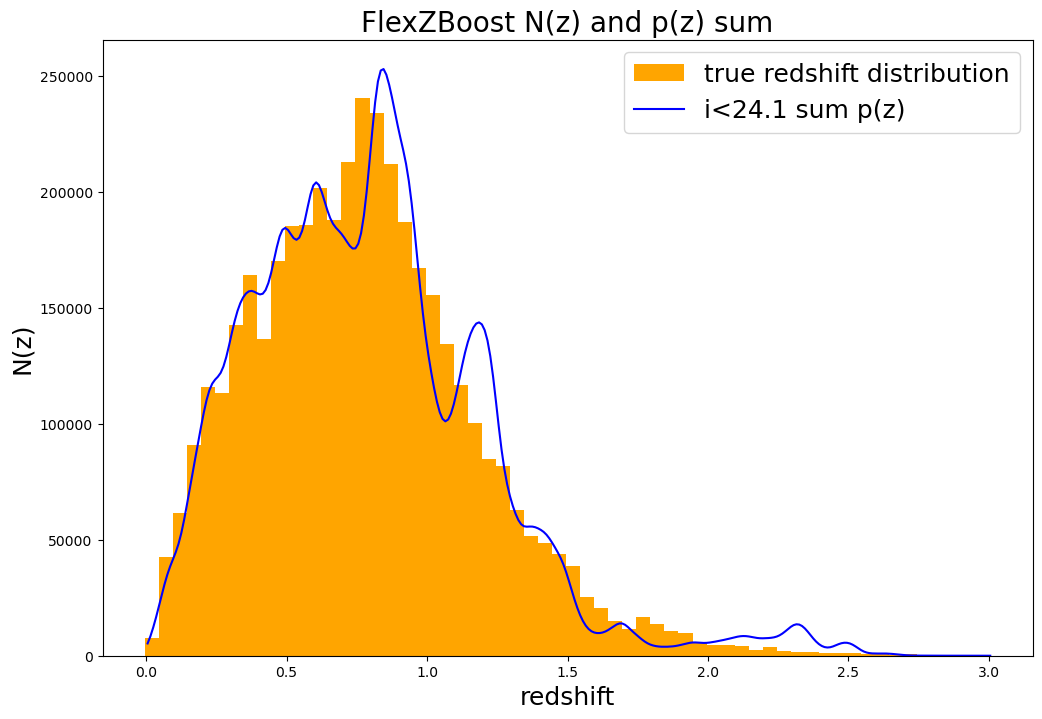

In [8]:
fig = plt.figure(figsize=(12,8))
nzsum = np.sum(total_pzdict['pdf'])
szbins = np.arange(-0.005,3.005,0.05)
plt.hist(total_pzdict['specz'],bins=szbins,color='orange',label='true redshift distribution')
plt.plot(zgrid,5*nzsum,c='b',label=f"i<{magcut} sum p(z)")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.title("FlexZBoost N(z) and p(z) sum",fontsize=20)
plt.legend(loc = 'upper right',fontsize=18);

## Make Sources

In [45]:
sources_cuts = [[0.0, 0.35],
               [0.35, 0.537],
               [0.537, 0.712],
               [0.712, 0.96],
               [0.96, 3.0]]
spec_sources_cuts = [[0.0, 0.7],
                    [0.0, 1.0],
                    [0.3, 1.3],
                    [0.5, 1.5],
                    [1.5, 3.0]]

lenses_cuts = [[0.2, 0.4],
               [0.4, 0.6],
               [0.6, 0.9],
               [0.8, 1.0],
               [1.0, 1.2]]
spec_lenses_cuts = [[0.0, 0.6],
                    [0.0, 1.0],
                    [0.3, 1.0],
                    [0.5, 1.3],
                    [0.7, 1.5]]

def make_tomo_bins(total_pzdict, cuts, spec_cuts, mode='lens', normalize=False):
    for i in np.arange(len(cuts)):
        print(i)
        cut = cuts[i]
        spec_cut = spec_cuts[i]
        tomocut = ((total_pzdict['zmode']>cut[0]) & (total_pzdict['zmode']<=cut[1]))
        photo_pdf = np.array(total_pzdict['pdf'][tomocut])
        print("Make fiducial photo-z")
        photo_fid = np.sum(photo_pdf)
        if normalize:
            photo_norms = np.array([np.sum(pdf) for pdf in photo_pdf])
            photo_pdf = photo_pdf/photo_norms

        print("Generate photo-z dists")
        photo_cdf = np.array([np.cumsum(pdf) for pdf in photo_pdf])

        print("Generate cdf interpolators")
        photo_cdf_i = np.array([interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in photo_cdf])

        print("Generate samples from interpolators")
        rs = np.array([np.random.uniform() for i in np.arange(1_000)])
        photo_samples = np.array([cdf(rs) for cdf in photo_cdf_i])

        print("Make histograms out of samples")
        zbins = np.linspace(spec_cut[0],spec_cut[1], 20)
        znodes = 0.5*(zbins[1:]+zbins[:-1])
        photo_hists = np.array([np.histogram(samples, bins=zbins, density=False)[0] for samples in photo_samples.T])
        if normalize:
            photo_hists_norms = np.array([np.sum(hist) for hist in photo_hists])
            photo_hists = photo_hists.T/photo_hists_norms
        else:
            photo_hists = photo_hists.T

        print("Generate spectrographic dists")
        spec_zbins = np.arange(0.,3.01,0.02)
        spec_znodes = 0.5*(spec_zbins[1:]+spec_zbins[:-1])
        spec = total_pzdict['specz'][tomocut]
        spec_hist = np.histogram(spec, bins=zbins, density=False)[0]
        if normalize:
            spec_hist = spec_hist/np.sum(spec_hist)
    
        file_name = './cut_photo_cats/{}_{}.npz'.format(mode, i)
        data= {'znodes':=znodes,
               'spec_znodes':=spec_znodes,
               'photo_hists':=photo_hists,
               'photo_fid':=photo_fid,
               'spec_hist':=spec_hist}
        np.save(file_name, 
               data=data)
   

SyntaxError: cannot use assignment expressions with literal (1403872235.py, line 65)

In [46]:
make_tomo_bins(total_pzdict, source_cuts, spec_source_cuts, mode='lens')

0
Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists


TypeError: save() got an unexpected keyword argument 'znodes'

In [10]:
source_1 = make_tomo_realizations(total_pzdict, source_cuts[0], spec_source_cuts[0]) 
np.savez('./cut_photo_cats/source_1.npz', source_1)
source_2 = make_tomo_realizations(total_pzdict, source_cuts[1], spec_source_cuts[1])
np.savez('./cut_photo_cats/source_2.npz', source_2)
source_3 = make_tomo_realizations(total_pzdict, source_cuts[2], spec_source_cuts[2])
np.savez('./cut_photo_cats/source_3.npz', source_3)
source_4 = make_tomo_realizations(total_pzdict, source_cuts[3], spec_source_cuts[3])
np.savez('./cut_photo_cats/source_4.npz', source_4)
source_5 = make_tomo_realizations(total_pzdict, source_cuts[4], spec_source_cuts[4])
np.savez('./cut_photo_cats/source_5.npz', source_5)

Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists


In [28]:
source_1 = np.load('./cut_photo_cats/source_1.npz', allow_pickle=True)
source_1['arr_0']

array({'zphoto': array([0.01842105, 0.05526316, 0.09210526, 0.12894737, 0.16578947,
       0.20263158, 0.23947368, 0.27631579, 0.31315789, 0.35      ,
       0.38684211, 0.42368421, 0.46052632, 0.49736842, 0.53421053,
       0.57105263, 0.60789474, 0.64473684, 0.68157895]), 'zspec': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01, 1.03, 1.05, 1.07, 1.09,
       1.11, 1.13, 1.15, 1.17, 1.19, 1.21, 1.23, 1.25, 1.27, 1.29, 1.31,
       1.33, 1.35, 1.37, 1.39, 1.41, 1.43, 1.45, 1.47, 1.49, 1.51, 1.53,
       1.55, 1.57, 1.59, 1.61, 1.63, 1.65, 1.67, 1.69, 1.71, 1.73, 1.75,
       1.77, 1.79, 1.81, 1.83, 1.85, 1.87, 1.89, 1.91, 1.93, 1.95, 1.97,
       1.99, 2.01, 2.03, 2.05, 2.07, 2.09, 2.11, 2.13, 2.15

In [ ]:
tomocut_1 = ((total_pzdict['zmode']>0.0) & (total_pzdict['zmode']<=0.35))
tomocut_2 = ((total_pzdict['zmode']>0.35) & (total_pzdict['zmode']<=0.537))
tomocut_3 = ((total_pzdict['zmode']>0.537) & (total_pzdict['zmode']<=0.712))
tomocut_4 = ((total_pzdict['zmode']>0.712) & (total_pzdict['zmode']<=0.96))
tomocut_5 = ((total_pzdict['zmode']>0.96) & (total_pzdict['zmode']<=3.0))

print("Make fiducial photo-z")
bin_1_photo_pdf = np.array(total_pzdict['pdf'][tomocut_1])
bin_2_photo_pdf = np.array(total_pzdict['pdf'][tomocut_2])
bin_3_photo_pdf = np.array(total_pzdict['pdf'][tomocut_3])
bin_4_photo_pdf = np.array(total_pzdict['pdf'][tomocut_4])
bin_5_photo_pdf = np.array(total_pzdict['pdf'][tomocut_5])
bin_1_photo_fid = np.sum(bin_1_photo_pdf) #/ np.sum(np.sum(bin_1_photo_pdf))
bin_2_photo_fid = np.sum(bin_2_photo_pdf) #/ np.sum(np.sum(bin_2_photo_pdf))
bin_3_photo_fid = np.sum(bin_3_photo_pdf) #/ np.sum(np.sum(bin_3_photo_pdf))
bin_4_photo_fid = np.sum(bin_4_photo_pdf) #/ np.sum(np.sum(bin_4_photo_pdf))
bin_5_photo_fid = np.sum(bin_5_photo_pdf) #/ np.sum(np.sum(bin_4_photo_pdf))

print("Generate photo-z dists")
bin_1_photo_norms = np.array([np.sum(pdf) for pdf in bin_1_photo_pdf])
bin_2_photo_norms = np.array([np.sum(pdf) for pdf in bin_2_photo_pdf])
bin_3_photo_norms = np.array([np.sum(pdf) for pdf in bin_3_photo_pdf])
bin_4_photo_norms = np.array([np.sum(pdf) for pdf in bin_4_photo_pdf])
bin_5_photo_norms = np.array([np.sum(pdf) for pdf in bin_5_photo_pdf])
bin_1_photo_pdf = bin_1_photo_pdf#/bin_1_photo_norms
bin_2_photo_pdf = bin_2_photo_pdf#/bin_2_photo_norms
bin_3_photo_pdf = bin_3_photo_pdf#/bin_3_photo_norms
bin_4_photo_pdf = bin_4_photo_pdf#/bin_4_photo_norms
bin_5_photo_pdf = bin_5_photo_pdf#/bin_4_photo_norms
bin_1_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_1_photo_pdf])
bin_2_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_2_photo_pdf])
bin_3_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_3_photo_pdf])
bin_4_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_4_photo_pdf])
bin_5_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_5_photo_pdf])

print("Generate cdf interpolators")
bin_1_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_1_photo_cdf])
bin_2_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_2_photo_cdf])
bin_3_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_3_photo_cdf])
bin_4_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_4_photo_cdf])
bin_5_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_5_photo_cdf])


print("Generate samples from interpolators")
bin_1_photo_samples = np.array([cdf(rs) for cdf in bin_1_photo_cdf_i])
bin_2_photo_samples = np.array([cdf(rs) for cdf in bin_2_photo_cdf_i])
bin_3_photo_samples = np.array([cdf(rs) for cdf in bin_3_photo_cdf_i])
bin_4_photo_samples = np.array([cdf(rs) for cdf in bin_4_photo_cdf_i])
bin_5_photo_samples = np.array([cdf(rs) for cdf in bin_5_photo_cdf_i])

print("Make histograms out of samples")
zbins_1 = np.linspace(0.,0.7, 20)
znodes_1 = 0.5*(zbins_1[1:]+zbins_1[:-1])
bin_1_photo_hists = np.array([np.histogram(samples, bins=zbins_1, density=False)[0] for samples in bin_1_photo_samples.T])
bin_1_photo_hists_norms = np.array([np.sum(hist) for hist in bin_1_photo_hists])
bin_1_photo_hists = bin_1_photo_hists.T#/bin_1_photo_hists_norms
zbins_2 = np.linspace(0.0, 1.0, 20)
znodes_2 = 0.5*(zbins_2[1:]+zbins_2[:-1])
bin_2_photo_hists = np.array([np.histogram(samples, bins=zbins_2, density=False)[0] for samples in bin_2_photo_samples.T])
bin_2_photo_hists_norms = np.array([np.sum(hist) for hist in bin_2_photo_hists])
bin_2_photo_hists = bin_2_photo_hists.T#/bin_2_photo_hists_norms
zbins_3 = np.linspace(0.3, 1.3, 20)
znodes_3 = 0.5*(zbins_3[1:]+zbins_3[:-1])
bin_3_photo_hists = np.array([np.histogram(samples, bins=zbins_3, density=False)[0] for samples in bin_3_photo_samples.T])
bin_3_photo_hists_norms = np.array([np.sum(hist) for hist in bin_3_photo_hists])
bin_3_photo_hists = bin_3_photo_hists.T#/bin_3_photo_hists_norms
zbins_4 = np.linspace(0.5, 1.5, 20)
znodes_4 = 0.5*(zbins_4[1:]+zbins_4[:-1])
bin_4_photo_hists = np.array([np.histogram(samples, bins=zbins_4, density=False)[0] for samples in bin_4_photo_samples.T])
bin_4_photo_hists_norms = np.array([np.sum(hist) for hist in bin_4_photo_hists])
bin_4_photo_hists = bin_4_photo_hists.T#/bin_4_photo_hists_norms
zbins_5 = np.linspace(0.7, 3, 20)
znodes_5 = 0.5*(zbins_5[1:]+zbins_5[:-1])
bin_5_photo_hists = np.array([np.histogram(samples, bins=zbins_5, density=False)[0] for samples in bin_5_photo_samples.T])
bin_5_photo_hists_norms = np.array([np.sum(hist) for hist in bin_5_photo_hists])
bin_5_photo_hists = bin_5_photo_hists.T#/bin_5_photo_hists_norms

print(np.mean(bin_1_photo_hists_norms))
print(np.mean(bin_2_photo_hists_norms))
print(np.mean(bin_3_photo_hists_norms))
print(np.mean(bin_4_photo_hists_norms))
print(np.mean(bin_5_photo_hists_norms))

print("Generate spectrographic dists")
zbins = np.arange(0.,3.01,0.02)
znodes = 0.5*(zbins[1:]+zbins[:-1])
bin_1_spec = total_pzdict['specz'][tomocut_1]
bin_1_spec_hist = np.histogram(bin_1_spec, bins=zbins, density=False)[0]
bin_1_spec_hist = bin_1_spec_hist#/np.sum(bin_1_spec_hist)
bin_2_spec = total_pzdict['specz'][tomocut_2]
bin_2_spec_hist = np.histogram(bin_2_spec, bins=zbins, density=False)[0]
bin_2_spec_hist = bin_2_spec_hist#/np.sum(bin_2_spec_hist)
bin_3_spec = total_pzdict['specz'][tomocut_3]
bin_3_spec_hist = np.histogram(bin_3_spec, bins=zbins, density=False)[0]
bin_3_spec_hist = bin_3_spec_hist#/np.sum(bin_3_spec_hist)
bin_4_spec = total_pzdict['specz'][tomocut_4]
bin_4_spec_hist = np.histogram(bin_4_spec, bins=zbins, density=False)[0]
bin_4_spec_hist = bin_4_spec_hist#/np.sum(bin_4_spec_hist)
bin_5_spec = total_pzdict['specz'][tomocut_5]
bin_5_spec_hist = np.histogram(bin_5_spec, bins=zbins, density=False)[0]
bin_5_spec_hist = bin_5_spec_hist#/np.sum(bin_5_spec_hist)

In [ ]:
#fig = plt.figure(figsize=(15,8))

plt.plot(znodes, 2*bin_1_spec_hist, 'k-')
plt.plot(znodes_1, bin_1_photo_hists, 'g-', alpha=0.01)
plt.plot(zgrid, 4.*bin_1_photo_fid, 'g-',label='Lens 1')

plt.plot(znodes, 3*bin_2_spec_hist, 'k-')
plt.plot(znodes_2, bin_2_photo_hists, '-', color='purple', alpha=0.01)
plt.plot(zgrid, 6*bin_2_photo_fid, '-', color='purple', label='Lens 2')

plt.plot(znodes, 2*bin_3_spec_hist, 'k-')
plt.plot(znodes_3, bin_3_photo_hists, 'r-', alpha=0.01)
plt.plot(zgrid, 4*bin_3_photo_fid, 'r-',label='Lens 3')

plt.plot(znodes, 3*bin_4_spec_hist, 'k-')
plt.plot(znodes_4, bin_4_photo_hists, '-', color='orange', alpha=0.01)
plt.plot(zgrid, 4.*bin_4_photo_fid, '-', color='orange', label='Lens 4')

plt.plot(znodes, 5*bin_5_spec_hist, 'k-')
plt.plot(znodes_5, bin_5_photo_hists, '-', color='blue', alpha=0.01)
plt.plot(zgrid, 10.*bin_5_photo_fid, '-', color='blue', label='Lens 5')

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()

In [ ]:
from numpy.linalg import eig, cholesky
def get_chol(cov):
    if not np.all(np.linalg.eigvals(cov) > 0):
        print('Warning: Covariance matrix is not positive definite')
        print('The covariance matrix will be regularized')
        jitter = 1e-15 * np.eye(cov.shape[0])
        w, v = eig(cov+jitter)
        w = np.real(np.abs(w))
        v = np.real(v)
        cov = v @ np.diag(np.abs(w)) @ v.T
        cov = np.tril(cov) + np.triu(cov.T, 1)
        if not np.all(np.linalg.eigvals(cov) > 0):
            print('Warning: regularization failed')
            print('The covariance matrix will be diagonalized')
            cov = np.diag(np.diag(cov))
    chol = cholesky(cov)
    return cov, chol

In [ ]:
cosmodc2_nzs = {}
cosmodc2_nzs['source_1'] = bin_1_photo_hists/bin_1_photo_hists_norms
cosmodc2_nzs['source_2'] = bin_2_photo_hists/bin_2_photo_hists_norms
cosmodc2_nzs['source_3'] = bin_3_photo_hists/bin_3_photo_hists_norms
cosmodc2_nzs['source_4'] = bin_4_photo_hists/bin_4_photo_hists_norms
cosmodc2_nzs['source_5'] = bin_5_photo_hists/bin_5_photo_hists_norms

cosmodc2_nzs['source_z1'] = znodes_1
cosmodc2_nzs['source_z2'] = znodes_2
cosmodc2_nzs['source_z3'] = znodes_3
cosmodc2_nzs['source_z4'] = znodes_4
cosmodc2_nzs['source_z5'] = znodes_5

In [ ]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k", "k"]
figure, axis = plt.subplots(2, 5, figsize=(20,8))
figure.subplots_adjust(wspace=0, hspace=0.0)
i = 0
keys = ['source_1', 'source_2', 'source_3', 'source_4', 'source_5']
for name in keys:
    nzs = np.array(cosmodc2_nzs[name])
    zs = np.array(cosmodc2_nzs['source_z{}'.format(i+1)])
    m = np.mean(nzs, axis=1)
    s = np.std(nzs, axis=1)
    cov = np.cov(nzs)
    cov, _ = get_chol(cov)
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zs, m, yerr=err,
                        fmt='{}o-'.format(colorss[i]),
                        label="$CosmoDC2_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$n(z)_{}$".format(i))
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zs), max(zs), max(zs), min(zs)])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

## Make Lenses

In [ ]:
tomocut_1 = ((total_pzdict['zmode']>0.2) & (total_pzdict['zmode']<=0.4))
tomocut_2 = ((total_pzdict['zmode']>0.4) & (total_pzdict['zmode']<=0.6))
tomocut_3 = ((total_pzdict['zmode']>0.6) & (total_pzdict['zmode']<=0.8))
tomocut_4 = ((total_pzdict['zmode']>0.8) & (total_pzdict['zmode']<=1.0))
tomocut_5 = ((total_pzdict['zmode']>1.0) & (total_pzdict['zmode']<=1.2))

print("Make fiducial photo-z")
bin_1_photo_pdf = np.array(total_pzdict['pdf'][tomocut_1])
bin_2_photo_pdf = np.array(total_pzdict['pdf'][tomocut_2])
bin_3_photo_pdf = np.array(total_pzdict['pdf'][tomocut_3])
bin_4_photo_pdf = np.array(total_pzdict['pdf'][tomocut_4])
bin_5_photo_pdf = np.array(total_pzdict['pdf'][tomocut_5])
bin_1_photo_fid = np.sum(bin_1_photo_pdf) #/ np.sum(np.sum(bin_1_photo_pdf))
bin_2_photo_fid = np.sum(bin_2_photo_pdf) #/ np.sum(np.sum(bin_2_photo_pdf))
bin_3_photo_fid = np.sum(bin_3_photo_pdf) #/ np.sum(np.sum(bin_3_photo_pdf))
bin_4_photo_fid = np.sum(bin_4_photo_pdf) #/ np.sum(np.sum(bin_4_photo_pdf))
bin_5_photo_fid = np.sum(bin_5_photo_pdf) #/ np.sum(np.sum(bin_4_photo_pdf))

print("Generate photo-z dists")
bin_1_photo_norms = np.array([np.sum(pdf) for pdf in bin_1_photo_pdf])
bin_2_photo_norms = np.array([np.sum(pdf) for pdf in bin_2_photo_pdf])
bin_3_photo_norms = np.array([np.sum(pdf) for pdf in bin_3_photo_pdf])
bin_4_photo_norms = np.array([np.sum(pdf) for pdf in bin_4_photo_pdf])
bin_5_photo_norms = np.array([np.sum(pdf) for pdf in bin_5_photo_pdf])
bin_1_photo_pdf = bin_1_photo_pdf#/bin_1_photo_norms
bin_2_photo_pdf = bin_2_photo_pdf#/bin_2_photo_norms
bin_3_photo_pdf = bin_3_photo_pdf#/bin_3_photo_norms
bin_4_photo_pdf = bin_4_photo_pdf#/bin_4_photo_norms
bin_5_photo_pdf = bin_5_photo_pdf#/bin_4_photo_norms
bin_1_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_1_photo_pdf])
bin_2_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_2_photo_pdf])
bin_3_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_3_photo_pdf])
bin_4_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_4_photo_pdf])
bin_5_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_5_photo_pdf])

print("Generate cdf interpolators")
bin_1_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_1_photo_cdf])
bin_2_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_2_photo_cdf])
bin_3_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_3_photo_cdf])
bin_4_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_4_photo_cdf])
bin_5_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_5_photo_cdf])


print("Generate samples from interpolators")
rs = np.array([np.random.uniform() for i in np.arange(1_000)])
bin_1_photo_samples = np.array([cdf(rs) for cdf in bin_1_photo_cdf_i])
bin_2_photo_samples = np.array([cdf(rs) for cdf in bin_2_photo_cdf_i])
bin_3_photo_samples = np.array([cdf(rs) for cdf in bin_3_photo_cdf_i])
bin_4_photo_samples = np.array([cdf(rs) for cdf in bin_4_photo_cdf_i])
bin_5_photo_samples = np.array([cdf(rs) for cdf in bin_5_photo_cdf_i])

print("Make histograms out of samples")
zbins_1 = np.linspace(0.,0.6, 20)
znodes_1 = 0.5*(zbins_1[1:]+zbins_1[:-1])
bin_1_photo_hists = np.array([np.histogram(samples, bins=zbins_1, density=False)[0] for samples in bin_1_photo_samples.T])
bin_1_photo_hists_norms = np.array([np.sum(hist) for hist in bin_1_photo_hists])
bin_1_photo_hists = bin_1_photo_hists.T#/bin_1_photo_hists_norms
zbins_2 = np.linspace(0.0, 1.0, 20)
znodes_2 = 0.5*(zbins_2[1:]+zbins_2[:-1])
bin_2_photo_hists = np.array([np.histogram(samples, bins=zbins_2, density=False)[0] for samples in bin_2_photo_samples.T])
bin_2_photo_hists_norms = np.array([np.sum(hist) for hist in bin_2_photo_hists])
bin_2_photo_hists = bin_2_photo_hists.T#/bin_2_photo_hists_norms
zbins_3 = np.linspace(0.3, 1.0, 20)
znodes_3 = 0.5*(zbins_3[1:]+zbins_3[:-1])
bin_3_photo_hists = np.array([np.histogram(samples, bins=zbins_3, density=False)[0] for samples in bin_3_photo_samples.T])
bin_3_photo_hists_norms = np.array([np.sum(hist) for hist in bin_3_photo_hists])
bin_3_photo_hists = bin_3_photo_hists.T#/bin_3_photo_hists_norms
zbins_4 = np.linspace(0.5, 1.3, 20)
znodes_4 = 0.5*(zbins_4[1:]+zbins_4[:-1])
bin_4_photo_hists = np.array([np.histogram(samples, bins=zbins_4, density=False)[0] for samples in bin_4_photo_samples.T])
bin_4_photo_hists_norms = np.array([np.sum(hist) for hist in bin_4_photo_hists])
bin_4_photo_hists = bin_4_photo_hists.T#/bin_4_photo_hists_norms
zbins_5 = np.linspace(0.7, 1.5, 20)
znodes_5 = 0.5*(zbins_5[1:]+zbins_5[:-1])
bin_5_photo_hists = np.array([np.histogram(samples, bins=zbins_5, density=False)[0] for samples in bin_5_photo_samples.T])
bin_5_photo_hists_norms = np.array([np.sum(hist) for hist in bin_5_photo_hists])
bin_5_photo_hists = bin_5_photo_hists.T#/bin_5_photo_hists_norms

print(np.mean(bin_1_photo_hists_norms))
print(np.mean(bin_2_photo_hists_norms))
print(np.mean(bin_3_photo_hists_norms))
print(np.mean(bin_4_photo_hists_norms))
print(np.mean(bin_5_photo_hists_norms))

print("Generate spectrographic dists")
zbins = np.arange(0.,3.01,0.02)
znodes = 0.5*(zbins[1:]+zbins[:-1])
bin_1_spec = total_pzdict['specz'][tomocut_1]
bin_1_spec_hist = np.histogram(bin_1_spec, bins=zbins, density=False)[0]
bin_1_spec_hist = bin_1_spec_hist#/np.sum(bin_1_spec_hist)
bin_2_spec = total_pzdict['specz'][tomocut_2]
bin_2_spec_hist = np.histogram(bin_2_spec, bins=zbins, density=False)[0]
bin_2_spec_hist = bin_2_spec_hist#/np.sum(bin_2_spec_hist)
bin_3_spec = total_pzdict['specz'][tomocut_3]
bin_3_spec_hist = np.histogram(bin_3_spec, bins=zbins, density=False)[0]
bin_3_spec_hist = bin_3_spec_hist#/np.sum(bin_3_spec_hist)
bin_4_spec = total_pzdict['specz'][tomocut_4]
bin_4_spec_hist = np.histogram(bin_4_spec, bins=zbins, density=False)[0]
bin_4_spec_hist = bin_4_spec_hist#/np.sum(bin_4_spec_hist)
bin_5_spec = total_pzdict['specz'][tomocut_5]
bin_5_spec_hist = np.histogram(bin_5_spec, bins=zbins, density=False)[0]
bin_5_spec_hist = bin_5_spec_hist#/np.sum(bin_5_spec_hist)

In [ ]:
#fig = plt.figure(figsize=(15,8))

plt.plot(znodes, 2*bin_1_spec_hist, 'k-')
plt.plot(znodes_1, bin_1_photo_hists, 'g-', alpha=0.01)
plt.plot(zgrid, 4.*bin_1_photo_fid, 'g-',label='Source 1')

plt.plot(znodes, 3*bin_2_spec_hist, 'k-')
plt.plot(znodes_2, bin_2_photo_hists, '-', color='purple', alpha=0.01)
plt.plot(zgrid, 4*bin_2_photo_fid, '-', color='purple', label='Source 2')

plt.plot(znodes, 2*bin_3_spec_hist, 'k-')
plt.plot(znodes_3, bin_3_photo_hists, 'r-', alpha=0.01)
plt.plot(zgrid, 4*bin_3_photo_fid, 'r-',label='Source 3')

plt.plot(znodes, 2*bin_4_spec_hist, 'k-')
plt.plot(znodes_4, bin_4_photo_hists, '-', color='orange', alpha=0.01)
plt.plot(zgrid, 4.*bin_4_photo_fid, '-', color='orange', label='Source 4')

plt.plot(znodes, 2*bin_5_spec_hist, 'k-')
plt.plot(znodes_5, bin_5_photo_hists, '-', color='blue', alpha=0.01)
plt.plot(zgrid, 4.*bin_5_photo_fid, '-', color='blue', label='Source 5')

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()

In [ ]:
cosmodc2_nzs['lens_1'] = bin_1_photo_hists/bin_1_photo_hists_norms
cosmodc2_nzs['lens_2'] = bin_2_photo_hists/bin_2_photo_hists_norms
cosmodc2_nzs['lens_3'] = bin_3_photo_hists/bin_3_photo_hists_norms
cosmodc2_nzs['lens_4'] = bin_4_photo_hists/bin_4_photo_hists_norms
cosmodc2_nzs['lens_5'] = bin_5_photo_hists/bin_5_photo_hists_norms

cosmodc2_nzs['lens_z1'] = znodes_1
cosmodc2_nzs['lens_z2'] = znodes_2
cosmodc2_nzs['lens_z3'] = znodes_3
cosmodc2_nzs['lens_z4'] = znodes_4
cosmodc2_nzs['lens_z5'] = znodes_5

In [ ]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k", "k"]
figure, axis = plt.subplots(2, 5, figsize=(20,8))
figure.subplots_adjust(wspace=0, hspace=0.0)
i = 0
keys = ['lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
for name in keys:
    nzs = np.array(cosmodc2_nzs[name])
    zs = np.array(cosmodc2_nzs['lens_z{}'.format(i+1)])
    m = np.mean(nzs, axis=1)
    s = np.std(nzs, axis=1)
    cov = np.cov(nzs)
    cov, _ = get_chol(cov)
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zs, m, yerr=err,
                        fmt='{}o-'.format(colorss[i]),
                        label="$CosmoDC2_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$n(z)_{}$".format(i))
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zs), max(zs), max(zs), min(zs)])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()